# 5.4-Tumoral T-helper clonotypes

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-27"

## Introduction

Check clonotypes in T-helpers

## Libraries

In [2]:
options(warn = -1, verbose = FALSE)
suppressMessages(suppressWarnings({
library(Seurat)
library(scRepertoire)
library(here)
library(glue)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(dittoSeq)
library(cowplot)
}))

## Load data

In [3]:
source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))
source(here("utils/style.R"))

In [4]:
seurat_obj <- readRDS(here(glue("{annot}/{robj_dir}/4.2.2-subset_thelper.rds")))
seurat_obj@meta.data$barcode <- rownames(seurat_obj@meta.data)

### Load TCR information

In [5]:
# depending on clone call
mode = "nt" 
chain = "TRB"

In [6]:
source(here("SCGRES_83_120/misc/paths.R"))

tumor_tcr <- readRDS(here(glue("{tcr}/{robj_dir}/5.0-tumorTCR_{mode}_{chain}.rds")))
tumor_tcr@meta.data$cdr3 <- substr(tumor_tcr@meta.data$CTnt, start = 3 + 1, stop = nchar(tumor_tcr@meta.data$CTnt) - 3)

In [7]:
tcr_info <- tumor_tcr@meta.data %>%
    dplyr::select(c('CTgene','CTnt','CTaa',
                    'CTstrict','Frequency','cloneType',
                     'cdr3'))

In [8]:
tcr_info <- tcr_info[colnames(seurat_obj), ]

dim(tcr_info)
dim(seurat_obj@meta.data)

[1] 1744    7

[1] 1744   21

In [9]:
seurat_obj@meta.data$cdr3 <- tcr_info$cdr3
seurat_obj@meta.data$Frequency <- tcr_info$Frequency
seurat_obj@meta.data$cloneType <- tcr_info$cloneType

## Plotting TCR 

In [10]:
col_name = "cdr3" # column with "clonotype" call 
lvl="CD4_nonTreg"

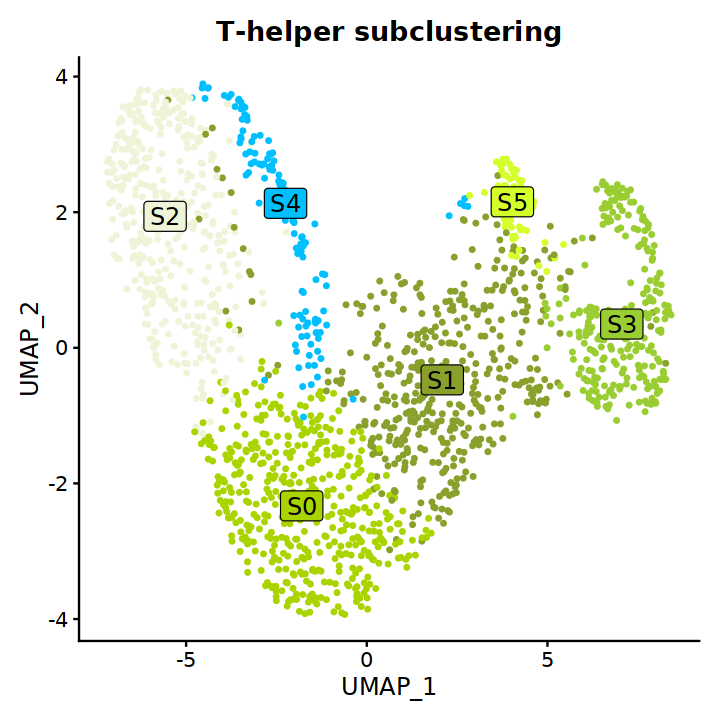

In [11]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
umap_annot <- DimPlot(seurat_obj, reduction = "umap",
        cols=unlist(th_pal),
        label = T,
        label.box = TRUE,
        label.size = 5,) + NoLegend() +
        labs(title=glue("T-helper subclustering")) + theme(plot.title = element_text(hjust = 0.5))
umap_annot

In [12]:
coord <- as.data.frame(seurat_obj[["umap"]]@cell.embeddings)
df_meta <- seurat_obj@meta.data[,c(lvl,"cdr3", "cloneType")]

# Convert row names to a column
coord <- rownames_to_column(coord, var = "RowNames")
df_meta <- rownames_to_column(df_meta, var = "RowNames")

# Perform a left join based on the RowNames column
df_plot <- left_join(coord, df_meta, by = "RowNames")

In [13]:
colorblind_vector <- colorRampPalette(rev(c("#0D0887FF", "#47039FFF", 
              "#7301A8FF", "#9C179EFF", "#BD3786FF", "#D8576BFF",
              "#ED7953FF","#FA9E3BFF", "#FDC926FF", "#F0F921FF")))

In [14]:
options(repr.plot.width = 7, repr.plot.height = 6, warn=-1,verbose = FALSE)
umap_exp <- DimPlot(seurat_obj, group.by = "cloneType") +
  labs(title=glue("Clonotypes")) + 
  theme(plot.title = element_text(hjust = 0.5)) +
scale_color_manual(values = colorblind_vector(5), na.value="grey")

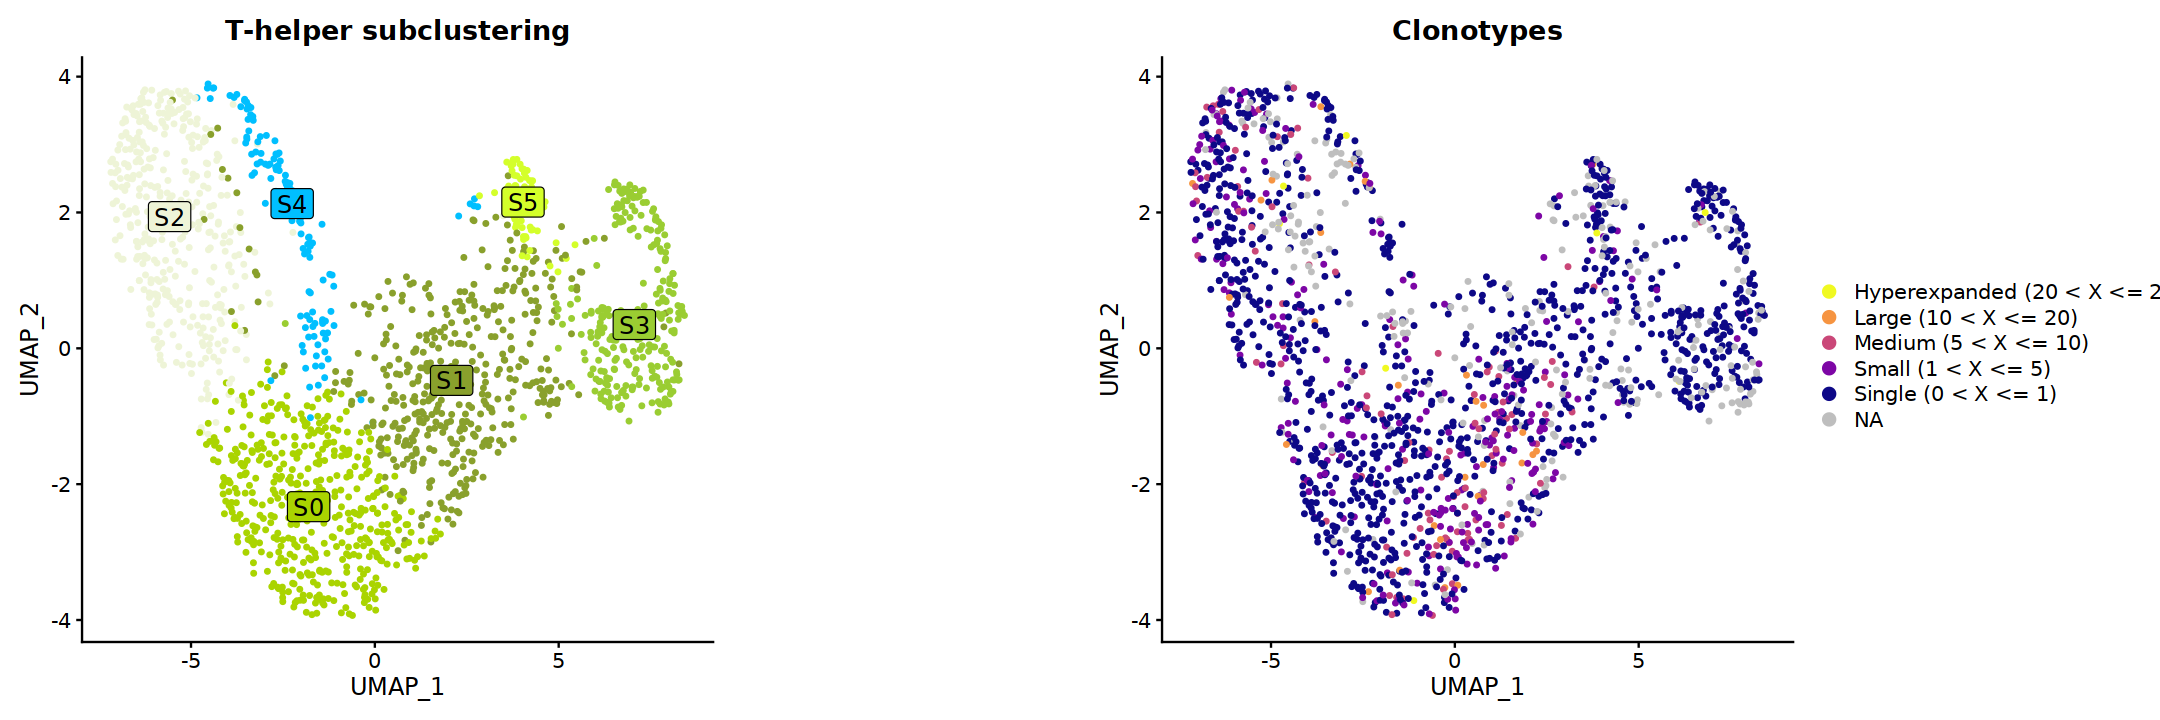

In [15]:
options(repr.plot.width = 18, repr.plot.height = 6, warn=-1,verbose = FALSE)
cowplot::plot_grid(plotlist = list(umap_annot, umap_exp),
                   align = "hv",
                   axis = "trbl",
                   ncol = 2,
                   nrow = 1)

### Per subcluster 

In [16]:
seurat_obj_filt <- subset(x = seurat_obj, idents=c("S0", "S1", "S2", "S5"))

In [17]:
df_tmp <- seurat_obj_filt@meta.data %>% 
    group_by(!!as.name(lvl), !!as.name(col_name)) %>%
    summarise(
        count = n()) %>% 
    dplyr::filter(!is.na(cdr3)) %>%
    dplyr::filter(count!=1) %>%
    mutate(category = case_when(count > 20  ~ "X > 20",
                                count > 10 & count <= 20 ~ "10 < X <= 20",
                                count > 5 & count <= 10 ~ "5 < X <= 10",
                                count > 1 & count <= 5 ~ "1 < X <= 5")) %>%
    arrange(desc(count)) 

`summarise()` has grouped output by 'CD4_nonTreg'. You can override using the `.groups` argument.


In [18]:
df_plot2 <- df_tmp %>%
  group_by(!!as.name(lvl), category) %>%
  summarise(count = n())

`summarise()` has grouped output by 'CD4_nonTreg'. You can override using the `.groups` argument.


In [19]:
df_plot2$category <- factor(df_plot2$category, levels = rev(c("1 < X <= 5", "5 < X <= 10", 
                                                              "10 < X <= 20", "X > 20")))
df_plot2$CD4_nonTreg <- factor(df_plot2$CD4_nonTreg, levels = c("S5", "S1", "S0", "S2", "S4"))

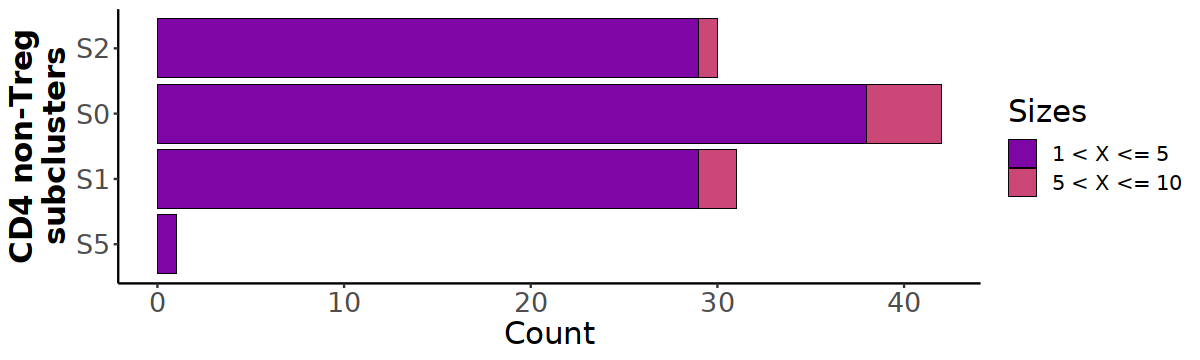

In [20]:
options(repr.plot.width = 10, repr.plot.height = 3, warn=-1,verbose = FALSE)
bp <- barplot_clonotypes(df_plot2, lvl, "CD4 non-Treg\nsubclusters")
bp

In [21]:
ggsave(plot = bp, width = 10, height = 3, dpi = 300, 
       file = here::here(glue::glue("{tcr}/{plt_dir}/5.0-CD4nonTregs_clono_size.svg")))

## Session Info

In [22]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1       dittoSeq_1.6.0      lubridate_1.9.3    
 [4] forcats_1.0.0       stringr_1.5.0       dplyr_1.1.3        
 [7] purrr_1.0.2         readr_2.1.4         tidyr_1.3.0        
[10] tibble_3.2.1        tidyverse_2.0.0     glue_1.6.2         
[13] here_1.0.1      